In [75]:
import pyfits
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as pl
%matplotlib inline

In [119]:
# Load the target pixel file
with pyfits.open('data/trappist1.fits.gz') as file:
    time = file[1].data.field('TIME')
    fpix = file[1].data.field('FLUX')
    fpix_err = file[1].data.field('FLUX_ERR')
    quality = file[1].data.field('QUALITY')
    naninds = np.where(np.isnan(time)[0])
    time = np.delete(time, naninds)
    fpix = np.delete(fpix, naninds, axis=0)
    fpix_err = np.delete(fpix_err, naninds, axis=0)
    quality = np.delete(quality, naninds)

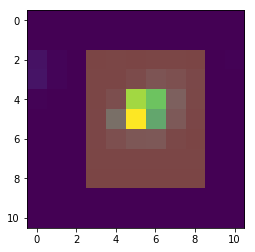

In [120]:
# Get a generous aperture
aperture=np.zeros(fpix.shape[1:])
aperture[2:9,3:9] = 1
pl.imshow(np.nansum([fpix[i] for i in range(len(fpix))], axis=0))
pl.imshow(aperture, alpha=0.3);

In [106]:
# Get bad cadences
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
badmask = []
for b in bad_bits:
    badmask += list(np.where(quality & 2 ** (b - 1))[0])
badmask = np.array(badmask, dtype=int)

# Get nan fluxes
nanflux = np.where(np.isnan(flux))[0]

# Join
badmask = np.array(list(set(badmask).union(set(nanflux))), dtype=int)

# Delete from light curve for simplicity
time = np.delete(time, badmask)
fpix = np.delete(fpix, badmask, axis=0)
fpix_err = np.delete(fpix_err, badmask, axis=0)
quality = np.delete(quality, badmask)
flux = np.sum(fpix, axis=(1,2))

# Normalize the light curve
baseline = np.nanmean(flux)
fpix /= baseline
fpix_err /= baseline

# Recompute the total flux
flux = np.sum(fpix, axis=(1,2))

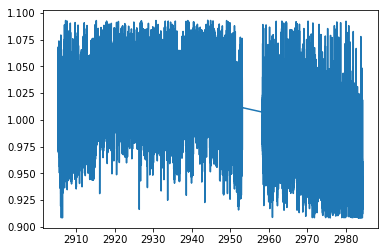

In [107]:
# Initial sigma clipping (aggressive at 3 sigma)
med = np.nanmedian(flux)
MAD = 1.4826 * np.nanmedian(np.abs(flux - med))
outliers = np.where((flux > med + 3. * MAD) | (flux < med - 3. * MAD))[0]
pl.plot(np.delete(time, outliers), np.delete(flux, outliers));

In [108]:
# Initial first order PLD with a 50th order polynomial mean model
A = fpix.reshape(len(time), -1) / flux.reshape(-1, 1)
A = np.hstack((A, np.array([np.linspace(0, 1, len(time)) ** n for n in range(50)]).T))

# Mask the outliers
A_ = np.delete(A, outliers, axis=0)

# Solve the linear equation
w = np.linalg.solve(np.dot(A_.T, A_), np.dot(A_.T, np.delete(flux, outliers)))
model = np.dot(A, w)
detrended_flux = 1 + flux - model

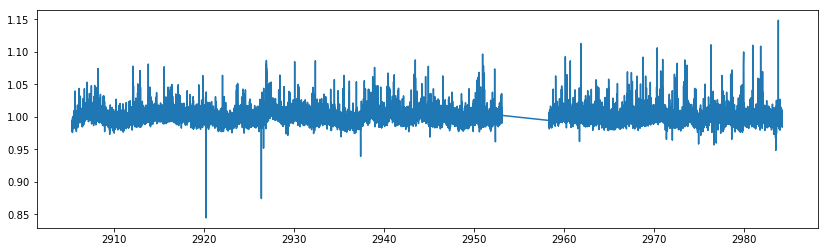

In [109]:
# Plot the de-trended light curve
fig, ax = pl.subplots(1, figsize=(14, 4))
pl.plot(np.delete(time, outliers), np.delete(detrended_flux, outliers));

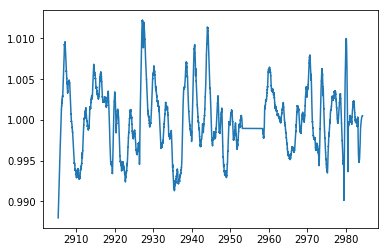

In [114]:
# Do sigma-clipping again
smooth_flux = np.interp(time, np.delete(time, outliers), np.delete(detrended_flux, outliers))
smooth_flux = savgol_filter(smooth_flux, 1501, 2)
pl.plot(time, smooth_flux);

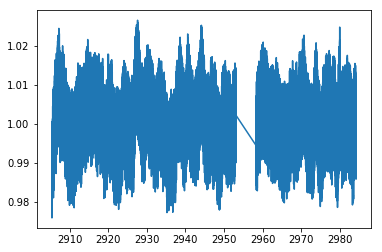

In [115]:
whitened_flux = detrended_flux - smooth_flux
med = np.nanmedian(whitened_flux)
MAD = 1.4826 * np.nanmedian(np.abs(whitened_flux - med))
outliers = np.where((whitened_flux > med + 3. * MAD) | (whitened_flux < med - 3. * MAD))[0]
pl.plot(np.delete(time, outliers), np.delete(detrended_flux, outliers));

In [117]:
# Sweet, now run our PLD model once more for a better intial guess at the light curve
A = fpix.reshape(len(time), -1) / flux.reshape(-1, 1)
A = np.hstack((A, np.array([np.linspace(0, 1, len(time)) ** n for n in range(50)]).T))
A_ = np.delete(A, outliers, axis=0)

# Solve the linear equation
w = np.linalg.solve(np.dot(A_.T, A_), np.dot(A_.T, np.delete(flux, outliers)))
model = np.dot(A, w)
detrended_flux = 1 + flux - model

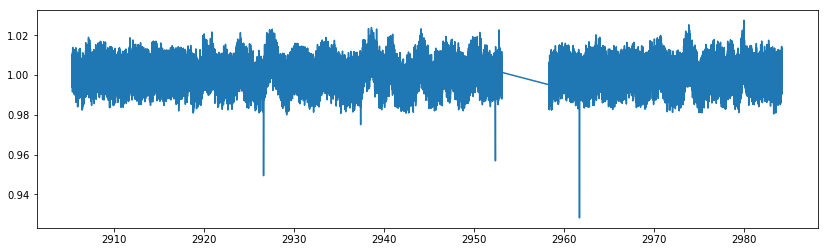

In [118]:
# Plot the de-trended light curve
fig, ax = pl.subplots(1, figsize=(14, 4))
pl.plot(np.delete(time, outliers), np.delete(detrended_flux, outliers));